<a href="https://colab.research.google.com/github/nitinnk09/auto-question-gen-ocr-nlp/blob/main/iocl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
!pip uninstall -y fpdf2
!pip install -U --quiet fpdf==1.7.2


In [ ]:
# @title
!pip install --quiet --upgrade pillow==10.2.0
!pip install --quiet sentence-transformers==2.7.0
!pip install --quiet faiss-cpu


In [ ]:
# @title
!pip install -U --quiet google-generativeai faiss-cpu sentence-transformers pytesseract pymupdf pdf2image langchain-community langchain-core langchain-text-splitters opencv-python pillow fpdf==1.7.2
!apt-get install -y -qq poppler-utils tesseract-ocr fonts-dejavu


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.49.1 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.


In [ ]:


# STEP 2: Upload PDFs
from google.colab import files
import os, tempfile, getpass

print("Please upload one or more PDF files (you can select multiple files at once)...")
uploaded_files = files.upload()

# STEP 3: Imports
import fitz  # PyMuPDF
import pytesseract
from pdf2image import convert_from_path

# Correct imports for LangChain 0.2+
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

import google.generativeai as genai
from PIL import Image
import cv2
import numpy as np
from fpdf import FPDF
from datetime import datetime

# Image Preprocessing for OCR
def preprocess_image_for_ocr(pil_image):
    img = np.array(pil_image.convert("L"))  # Grayscale
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img = cv2.medianBlur(img, 3)
    img = cv2.resize(img, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)
    return Image.fromarray(img)

# STEP 4: Configure Gemini (avoid hardcoding keys)
print("Enter your Gemini API key (input is hidden):")
GEMINI_API_KEY = getpass.getpass().strip()   # <-- don't paste keys into code
genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel("gemini-2.0-flash")  # <-- no 'models/' prefix

# STEP 5: Extract Text from PDFs
all_docs = []

for name, data in uploaded_files.items():
    temp_path = os.path.join(tempfile.gettempdir(), name)
    with open(temp_path, "wb") as f:
        f.write(data)

    try:
        doc = fitz.open(temp_path)
        for page_num, page in enumerate(doc, start=1):
            text = page.get_text()

            # OCR fallback
            if not text.strip():
                print(f"Using OCR for Page {page_num} in {name}")
                images = convert_from_path(temp_path, first_page=page_num, last_page=page_num, dpi=200)
                preprocessed_img = preprocess_image_for_ocr(images[0])
                text = pytesseract.image_to_string(preprocessed_img)

            # Section header extraction (simple heuristic)
            section_title = ""
            for line in text.split("\n"):
                if line.strip().isupper() and len(line.strip()) > 15:
                    section_title = line.strip()
                    break

            splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=200)
            chunks = splitter.split_text(text)

            for chunk in chunks:
                metadata = {
                    "source": name,
                    "page_number": page_num,
                    "section": section_title or "Unknown"
                }
                all_docs.append(Document(page_content=chunk, metadata=metadata))

    except Exception as e:
        print(f"Failed to process {name}: {e}")

if not all_docs:
    raise RuntimeError("No text extracted from any PDF. Please check your uploads.")

# STEP 6: Create Embeddings & Retriever
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectordb = FAISS.from_documents(all_docs, embedding_model)
retriever = vectordb.as_retriever(search_type="similarity", search_kwargs={"k": 3})  # <-- create retriever

# STEP 7: Export Q&A to PDF with Sources
def export_qa_to_unicode_pdf(log, filename="qa_session_export.pdf"):
    pdf = FPDF()
    pdf.add_page()
    # Use a Unicode-capable font
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"
    pdf.add_font("DejaVu", "", fname=font_path, uni=True)
    pdf.set_font("DejaVu", size=12)
    pdf.set_auto_page_break(auto=True, margin=15)

    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    pdf.multi_cell(0, 10, f"Q&A Session Export - {now}\n", align="C")

    for idx, qa in enumerate(log, start=1):
        pdf.set_font("DejaVu", size=12)
        pdf.multi_cell(0, 10, f"Q{idx}: {qa['question']}", align="L")
        pdf.multi_cell(0, 10, f"A{idx}: {qa['answer']}", align="L")
        pdf.set_font("DejaVu", size=11)
        pdf.multi_cell(0, 10, "Sources:", align="L")
        for src in qa.get("sources", []):
            src_line = f"File: {src['source']} | Page: {src['page']} | Section: {src['section']}"
            pdf.multi_cell(0, 10, f"- {src_line}", align="L")
        pdf.multi_cell(0, 10, "-"*70)

    output_path = os.path.join(tempfile.gettempdir(), filename)
    pdf.output(output_path)

    from google.colab import files as colab_files
    colab_files.download(output_path)


# STEP 8: Q&A Loop with Source Collection
qa_log = []

print("\nAsk questions about your PDFs. Type 'exit' to finish.")
while True:
    question = input("\nEnter your question (or type 'exit' to quit): ").strip()
    if question.lower() == "exit":
        print("Session ended.")
        break

    # LangChain 0.2+: use invoke()
    relevant_docs = retriever.invoke(question)

    context = "\n\n".join(doc.page_content for doc in relevant_docs)
    prompt = f"""
Use the following context to answer the question.
If the answer isn't in the context, say you don't know.

Context:
{context}

Question: {question}
Answer:
""".strip()

    try:
        response = model.generate_content(prompt)
        answer = (response.text or "").strip() or "I couldn't generate an answer from the provided context."
        print("\nAnswer:")
        print(answer)

        # Extract source info
        sources_info = []
        for doc in relevant_docs:
            sources_info.append({
                "source": doc.metadata.get("source", "Unknown"),
                "page": doc.metadata.get("page_number", "Unknown"),
                "section": doc.metadata.get("section", "Unknown")
            })

        # Log Q&A with sources
        qa_log.append({
            "question": question,
            "answer": answer,
            "sources": sources_info
        })

        # Show sources
        print("\nSources:")
        for src in sources_info:
            print(f"File: {src['source']} | Page: {src['page']} | Section: {src['section']}")

    except Exception as e:
        print(f"Gemini error: {e}")
        continue

    # ✅ Ask user whether to export (ensure `choice` is defined before using it)
    choice = input("\nDo you want to export this Q&A session to Unicode PDF? (y/n): ").strip().lower()
    if choice == "y":
        export_qa_to_unicode_pdf(qa_log)
        print("PDF exported successfully.")


Please upload one or more PDF files (you can select multiple files at once)...


Saving bayes theoram.pdf to bayes theoram (2).pdf
Enter your Gemini API key (input is hidden):
··········
Using OCR for Page 13 in bayes theoram (2).pdf


/tmp/ipython-input-1812137953.py:85: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



Ask questions about your PDFs. Type 'exit' to finish.

Enter your question (or type 'exit' to quit): bayes

Answer:
I don't know.

Sources:
File: bayes theoram (2).pdf | Page: 13 | Section: Unknown
File: bayes theoram (2).pdf | Page: 5 | Section: Unknown
File: bayes theoram (2).pdf | Page: 7 | Section: Unknown

Do you want to export this Q&A session to Unicode PDF? (y/n): bayesian network

Enter your question (or type 'exit' to quit): bayesiuan neteork


Gemini error: 429 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: Resource exhausted. Please try again later. Please refer to https://cloud.google.com/vertex-ai/generative-ai/docs/error-code-429 for more details.

Enter your question (or type 'exit' to quit): bayesian network

Answer:
A Bayesian Network is a graphical representation of probabilistic relationships among a set of variables. It's a powerful tool for modeling uncertainty and making predictions in situations where multiple variables interact. It combines probability theory and graph theory to model complex systems and capture dependencies between variables, and it can be used for prediction, anomaly detection, diagnostics, automated insight, reasoning, time series prediction, and decision making under uncertainty. Bayesian Networks find applications in various fields such as healthcare, finance, and natural language processing. It is also known

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PDF exported successfully.

Enter your question (or type 'exit' to quit): bayes theorem

Answer:
According to the context, Bayes' Theorem is used to determine the conditional probability of event A when event B has already happened.

The general statement of Bayes’ theorem is “The conditional probability of an event A, given the occurrence of another event B, is equal to the product of the event of B, given A and the probability of A divided by the probability of event B.” i.e.

P ( A| B) = P(A⋀B) / P(B) = P ( B | A ) P ( A ) / P ( B )

Sources:
File: bayes theoram (2).pdf | Page: 7 | Section: Unknown
File: bayes theoram (2).pdf | Page: 1 | Section: P ( A| B) =  P(A⋀B) / P(B)  = P ( B | A ) P ( A ) / P ( B )
File: bayes theoram (2).pdf | Page: 12 | Section: Unknown

Do you want to export this Q&A session to Unicode PDF? (y/n): y


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PDF exported successfully.

Enter your question (or type 'exit' to quit): exit
Session ended.


In [ ]:
# @title
# === Quick Metrics Summary ===
import os, re, tempfile, fitz, pytesseract
from pdf2image import convert_from_path
from statistics import mean

def words(x): return set(re.findall(r"[A-Za-z0-9]+", (x or "").lower()))

# 1️⃣ OCR Accuracy
ocr_conf = []
for n, d in getattr(uploaded_files, "items", lambda:[])():
    path = os.path.join(tempfile.gettempdir(), n)
    for i, p in enumerate(fitz.open(path), 1):
        if not p.get_text().strip():
            img = convert_from_path(path, first_page=i, last_page=i, dpi=200)[0]
            data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)
            c = [int(v) for v in data["conf"] if str(v).isdigit() and int(v) >= 0]
            if c: ocr_conf.append(mean(c))
ocr = round(mean(ocr_conf), 1) if ocr_conf else None

# 2️⃣ Retrieval Precision@3 & 3️⃣ Answer Relevance
hits, sims = [], []
for qa in qa_log:
    q, a = qa["question"], qa["answer"]
    docs = retriever.invoke(q)
    qt, at = words(q), words(a)
    hits.append(any(len(words(d.page_content)&(qt|at))>5 for d in docs))
    ctx = " ".join(d.page_content for d in docs)
    sims.append(100*len(words(ctx)&at)/(len(words(ctx)|at) or 1))
prec = round(100*sum(hits)/len(hits),1) if hits else None
rel  = round(mean(sims),1) if sims else None

# 4️⃣ Export Reliability
pdf = os.path.join(tempfile.gettempdir(),"qa_session_export.pdf")
try:
    with fitz.open(pdf) as d: "".join(p.get_text() for p in d).encode("utf-8")
    exp = 100.0
except: exp = 0.0 if os.path.exists(pdf) else None

print("\n📊 Session Metrics:")
print(f"- OCR Accuracy: {ocr or 'N/A'}%")
print(f"- Retrieval Precision@3: {prec or 'N/A'}%")
print(f"- Answer Relevance: {rel or 'N/A'}%")
print(f"- Export Reliability: {exp or 'N/A'}%")



📊 Session Metrics:
- OCR Accuracy: 95.3%
- Retrieval Precision@3: 66.7%
- Answer Relevance: 33.4%
- Export Reliability: 100.0%


In [ ]:
# @title
import matplotlib.pyplot as plt

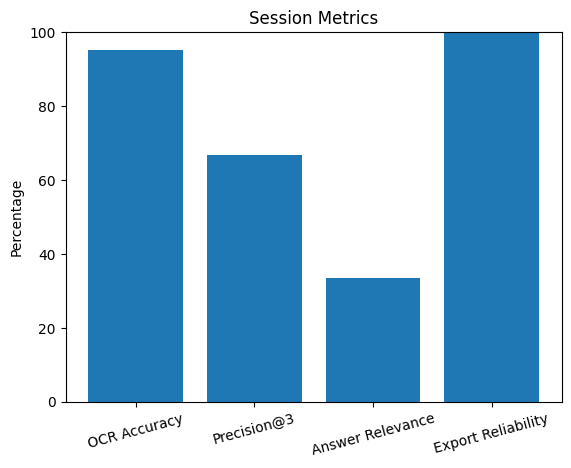

In [ ]:
# @title
labels, values = [], []
for lbl, val in [("OCR Accuracy", ocr), ("Precision@3", prec), ("Answer Relevance", rel), ("Export Reliability", exp)]:
    if isinstance(val, (int, float)): labels.append(lbl); values.append(val)

if values:
    plt.figure()
    plt.bar(labels, values)
    plt.ylabel("Percentage")
    plt.title("Session Metrics")
    plt.ylim(0, 100)
    plt.xticks(rotation=15)
    plt.show()
else:
    print("No metrics to plot yet (ask at least one question and/or export).")